In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import AutoMinorLocator
from scipy.interpolate import griddata

In [2]:
df_results = pd.concat((pd.read_csv(f, index_col=0) for f in Path('data/3D_pareto').rglob('results.csv')), ignore_index=True)
df_results.iloc[:,4:] *= 1000
df = df_results.groupby(list(df_results.columns[:4])).median().reset_index()
dft_times = {1: 8.33, 2: 10.02, 3: 14.80, 4: 19.18, 5: 91.99, 6: 996.14}
df['DFT Cost, minutes'] = df['Train Precision'].map(dft_times) * df['Subsample size'] / 60
print(df.columns)

Index(['Subsample size', 'Energy Weight', '2Jmax', 'Train Precision',
       'Subsampled Energy RMSE (train precision)',
       'Subsampled Force RMSE (train precision)',
       'Training Energy RMSE (train precision)',
       'Training Force RMSE (train precision)',
       'Testing Energy RMSE (train precision)',
       'Testing Force RMSE (train precision)',
       'Subsampled Energy RMSE (6th precision)',
       'Subsampled Force RMSE (6th precision)',
       'Training Energy RMSE (6th precision)',
       'Training Force RMSE (6th precision)',
       'Testing Energy RMSE (6th precision)',
       'Testing Force RMSE (6th precision)', 'DFT Cost, minutes'],
      dtype='object')


In [3]:
not_minima_list = []
for i in range(df.shape[0]):
    for j in range(df.shape[0]):
        if (df.iloc[i,-1] > df.iloc[j,-1]) and (df.iloc[i,-2] > df.iloc[j,-2]) and (df.iloc[i,-3] > df.iloc[j,-3]):
            not_minima_list.append(i)
            break
minima_list = [i for i in range(df.shape[0]) if i not in not_minima_list]
print(len(minima_list))
df_pareto = df.iloc[minima_list,:]

161


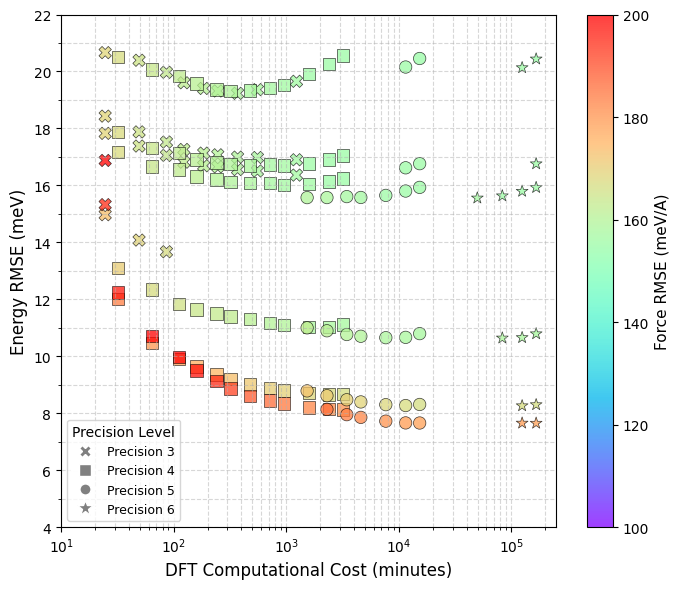

In [4]:
e_min, e_max = 4, 22
f_min, f_max = 100, 200
cost_min, cost_max = 10, 250000

markers_list = ['X', 's', 'o', '*']#['o', '^', 's', 'P', 'D', '*']
unique_precisions = sorted(df_pareto['Train Precision'].unique())[2:]
marker_map = {prec: markers_list[i % len(markers_list)] for i, prec in enumerate(unique_precisions)}

fig, ax = plt.subplots(figsize=(7, 6))
plotted_scatter_collection = None

color_norm = Normalize(vmin=f_min, vmax=f_max)
for precision_val in unique_precisions:
    subset_df = df_pareto[df_pareto['Train Precision'] == precision_val]
    if not subset_df.empty:
        plotted_scatter_collection = ax.scatter(
            subset_df['DFT Cost, minutes'],
            subset_df['Testing Energy RMSE (6th precision)'],
            marker=marker_map[precision_val],
            c=subset_df['Testing Force RMSE (6th precision)'],
            norm=color_norm,
            cmap='rainbow',
            s=80,
            alpha=0.75,
            edgecolors='k',
            linewidth=0.5
        )

ax.set_xscale('log')
ax.set_xlim(cost_min, cost_max)
ax.set_ylim(e_min, e_max)

if plotted_scatter_collection:
    cbar = fig.colorbar(plotted_scatter_collection, ax=ax)
    cbar.set_label('Force RMSE (meV/A)', fontsize=11)

ax.set_xlabel('DFT Computational Cost (minutes)', fontsize=12)
ax.set_ylabel('Energy RMSE (meV)', fontsize=12)
# ax.set_title('Energy RMSE vs. Cost by Force RMSE and Precision', fontsize=14)

legend_handles = [
    plt.Line2D([0], [0],
               marker=marker_map[prec_val],
               color='w', # Invisible line
               label=f'Precision {prec_val}',
               markerfacecolor='grey',
               markersize=12 if marker_map[prec_val] == '*' else 8)
    for prec_val in unique_precisions if prec_val in marker_map
]
if legend_handles:
    ax.legend(handles=legend_handles, title='Precision Level', fontsize=9, title_fontsize=10)

ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
plt.grid(True, which="both", ls="--", alpha=0.5)
fig.tight_layout()
plt.show()

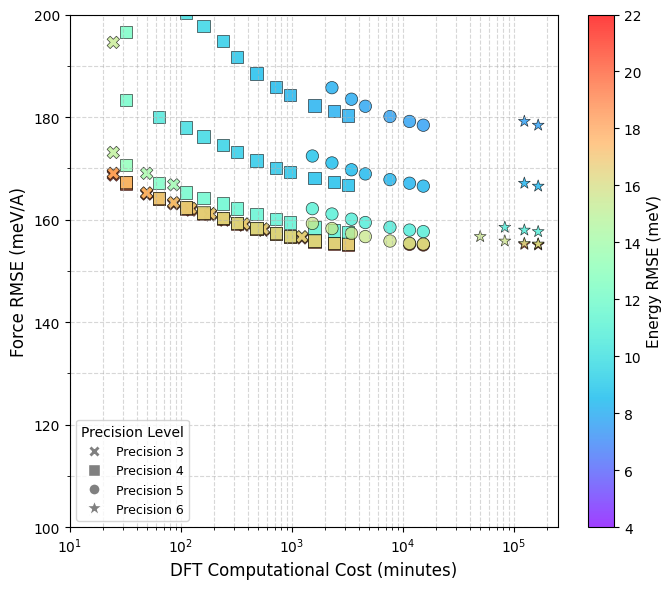

In [5]:
e_min, e_max = 4, 22
f_min, f_max = 100, 200
cost_min, cost_max = 10, 250000
markers_list = ['X', 's', 'o', '*']#['o', '^', 's', 'P', 'D', '*']
unique_precisions = sorted(df_pareto['Train Precision'].unique())[2:]
marker_map = {prec: markers_list[i % len(markers_list)] for i, prec in enumerate(unique_precisions)}

fig, ax = plt.subplots(figsize=(7, 6))
plotted_scatter_collection = None

color_norm = Normalize(vmin=e_min, vmax=e_max)
for precision_val in unique_precisions:
    subset_df = df_pareto[df_pareto['Train Precision'] == precision_val]
    if not subset_df.empty:
        plotted_scatter_collection = ax.scatter(
            subset_df['DFT Cost, minutes'],
            subset_df['Testing Force RMSE (6th precision)'],
            marker=marker_map[precision_val],
            c=subset_df['Testing Energy RMSE (6th precision)'],
            norm=color_norm,
            cmap='rainbow',
            s=80,
            alpha=0.75,
            edgecolors='k',
            linewidth=0.5
        )

ax.set_xscale('log')
ax.set_xlim(cost_min, cost_max)
ax.set_ylim(f_min, f_max)

if plotted_scatter_collection:
    cbar = fig.colorbar(plotted_scatter_collection, ax=ax)
    cbar.set_label('Energy RMSE (meV)', fontsize=11)

ax.set_xlabel('DFT Computational Cost (minutes)', fontsize=12)
ax.set_ylabel('Force RMSE (meV/A)', fontsize=12)
# ax.set_title('Force RMSE vs. Cost by Energy RMSE and Precision', fontsize=14)

legend_handles = [
    plt.Line2D([0], [0],
               marker=marker_map[prec_val],
               color='w', # Invisible line
               label=f'Precision {prec_val}',
               markerfacecolor='grey',
               markersize=12 if marker_map[prec_val] == '*' else 8)
    for prec_val in unique_precisions if prec_val in marker_map
]
if legend_handles:
    ax.legend(handles=legend_handles, title='Precision Level', fontsize=9, title_fontsize=10)

ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
plt.grid(True, which="both", ls="--", alpha=0.5)
fig.tight_layout()
plt.show()

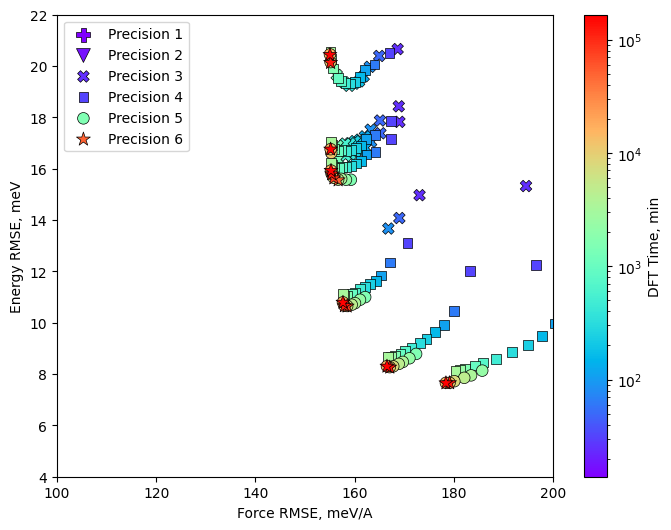

In [11]:
vmin = np.min(df_pareto['DFT Cost, minutes'])
vmax = np.max(df_pareto['DFT Cost, minutes'])

xb = [100,200]
yb = [4,22]

plt.figure(figsize=(8,6))

plt.scatter(df_pareto[df_pareto['Train Precision']==1]["Testing Force RMSE (6th precision)"],df_pareto[df_pareto['Train Precision']==1]["Testing Energy RMSE (6th precision)"], marker='P', s=100,
            c=df_pareto[df_pareto['Train Precision']==1]['DFT Cost, minutes'], cmap='rainbow', edgecolors='black', zorder=1, label='Precision 1', 
            linewidth=0.5, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.scatter(df_pareto[df_pareto['Train Precision']==2]["Testing Force RMSE (6th precision)"], df_pareto[df_pareto['Train Precision']==2]["Testing Energy RMSE (6th precision)"], marker='v', s=100,
            c=df_pareto[df_pareto['Train Precision']==2]['DFT Cost, minutes'], cmap='rainbow', edgecolors='black', zorder=2, label='Precision 2',
            linewidth=0.5, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.scatter(df_pareto[df_pareto['Train Precision']==3]["Testing Force RMSE (6th precision)"],
            df_pareto[df_pareto['Train Precision']==3]["Testing Energy RMSE (6th precision)"], marker='X', s=70,
            c=df_pareto[df_pareto['Train Precision']==3]['DFT Cost, minutes'], cmap='rainbow', edgecolors='black', zorder=3, label='Precision 3',
            linewidth=0.5, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.scatter(df_pareto[df_pareto['Train Precision']==4]["Testing Force RMSE (6th precision)"],
            df_pareto[df_pareto['Train Precision']==4]["Testing Energy RMSE (6th precision)"], marker='s', s=50,
            c=df_pareto[df_pareto['Train Precision']==4]['DFT Cost, minutes'], cmap='rainbow', edgecolors='black', zorder=4, label='Precision 4',
            linewidth=0.5, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.scatter(df_pareto[df_pareto['Train Precision']==5]["Testing Force RMSE (6th precision)"],
            df_pareto[df_pareto['Train Precision']==5]["Testing Energy RMSE (6th precision)"], marker='o', s=70,
            c=df_pareto[df_pareto['Train Precision']==5]['DFT Cost, minutes'], cmap='rainbow', edgecolors='black', zorder=5, label='Precision 5',
            linewidth=0.5, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.scatter(df_pareto[df_pareto['Train Precision']==6]["Testing Force RMSE (6th precision)"],
            df_pareto[df_pareto['Train Precision']==6]["Testing Energy RMSE (6th precision)"], marker='*', s=110,
            c=df_pareto[df_pareto['Train Precision']==6]['DFT Cost, minutes'], cmap='rainbow', edgecolors='black', zorder=6, label='Precision 6',
            linewidth=0.5, norm=LogNorm(vmin=vmin, vmax=vmax))

plt.legend(loc='upper left')
plt.xlabel("Force RMSE, meV/A")
plt.ylabel("Energy RMSE, meV")
cbar = plt.colorbar()
cbar.set_label('DFT Time, min')
plt.ylim(yb[0],yb[1])
plt.xlim(xb[0],xb[1])
plt.show()